### Importing necessary libraries & data files

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [3]:
customer_data = pd.read_csv('Bank Customer Churn.csv')

### Inspecting the dataframe

In [4]:
pd.options.display.max_rows = 999

# Set option to disable scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
customer_data.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,15647311,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,15619304,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,15701354,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,15737888,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [6]:
customer_data.shape

(10000, 12)

### Data Cleaning

In [7]:
customer_data.isna().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [8]:
customer_data = customer_data.drop(columns = ['customer_id'])

### Outlier Detection

In [9]:
customer_data.describe(include = 'all')

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000,10000,10000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000,10000.000
unique,NaN,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,France,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,5014,5457,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,650.529,NaN,NaN,38.922,5.013,76485.889,1.530,0.706,0.515,100090.240,0.204
std,96.653,NaN,NaN,10.488,2.892,62397.405,0.582,0.456,0.500,57510.493,0.403
min,350.000,NaN,NaN,18.000,0.000,0.000,1.000,0.000,0.000,11.580,0.000
25%,584.000,NaN,NaN,32.000,3.000,0.000,1.000,0.000,0.000,51002.110,0.000
50%,652.000,NaN,NaN,37.000,5.000,97198.540,1.000,1.000,1.000,100193.915,0.000
75%,718.000,NaN,NaN,44.000,7.000,127644.240,2.000,1.000,1.000,149388.247,0.000


In [10]:
def get_unique_values(df, column_names):
    """
    This function returns the unique values for one or more textual columns of a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        column_names (Union[str, List[str]]): The name(s) of the column(s) to analyze.
    
    Returns:
        dict: A dictionary with column names as keys and arrays of unique values as values.
    """
    # Initialize a dictionary to store the results
    unique_values_dict = {}

    # Ensure column_names is a list to simplify processing
    if isinstance(column_names, str):
        column_names = [column_names]
    
    # Iterate through the list of column names
    for column in column_names:
        if column in df.columns:
            unique_values_dict[column] = df[column].unique()
        else:
            unique_values_dict[column] = f"Error: Column '{column}' does not exist in the DataFrame."
    
    return unique_values_dict


In [11]:
unique_values = get_unique_values(customer_data, ['country', 'gender'])
print("Unique Values:", unique_values)

Unique Values: {'country': array(['France', 'Spain', 'Germany'], dtype=object), 'gender': array(['Female', 'Male'], dtype=object)}


### Exploratory Data Analysis (EDA)

In [12]:
customer_data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [13]:
def plot_unique_values(df, column):
    """
    Plots the quantity of unique values in a specified DataFrame column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column name for which unique values should be plotted.

    Returns:
    None
    """
    # Get the count of unique values
    unique_counts = df[column].value_counts()
    
    # Plot the data
    plt.figure(figsize=(5, 3))
    unique_counts.plot(kind='bar')
    plt.title(f'Quantity of Unique Values in Column: {column}')
    plt.xlabel('Unique Values')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

In [14]:
def plot_histogram(df, column, bins=10):
    """
    Plots a histogram for the values in a specified DataFrame column.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column (str): The column name for which the histogram should be plotted.
    bins (int): The number of bins for the histogram (default is 10).

    Returns:
    None
    """
    # Plot the histogram
    plt.figure(figsize=(5,3))
    plt.hist(df[column], bins=bins, edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

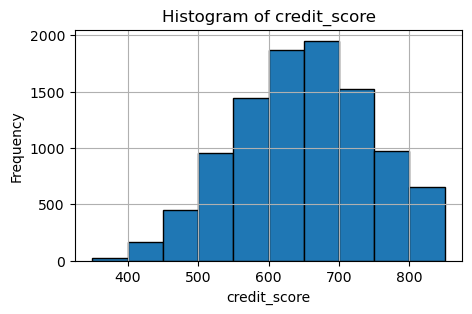

In [15]:
plot_histogram(customer_data, 'credit_score')

In [ ]:
plot_unique_values(customer_data, 'country')

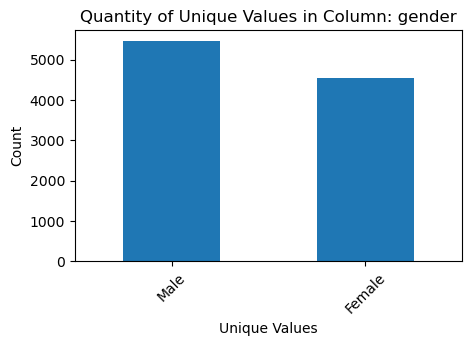

In [16]:
plot_unique_values(customer_data, 'gender')

In [ ]:
plot_histogram(customer_data, 'age')

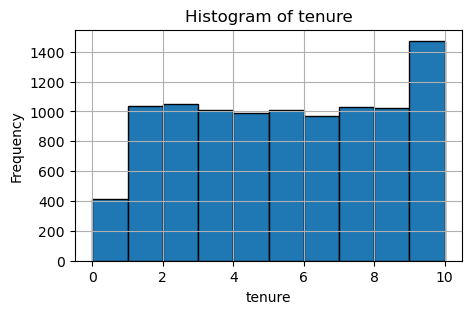

In [17]:
plot_histogram(customer_data, 'tenure')

In [ ]:
plot_histogram(customer_data, 'balance')

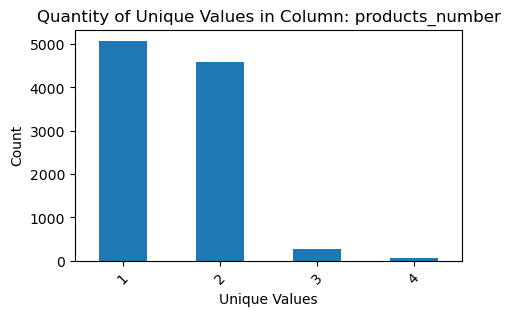

In [18]:
plot_unique_values(customer_data, 'products_number')

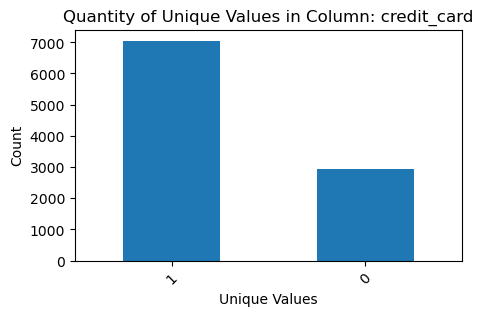

In [19]:
plot_unique_values(customer_data, 'credit_card')

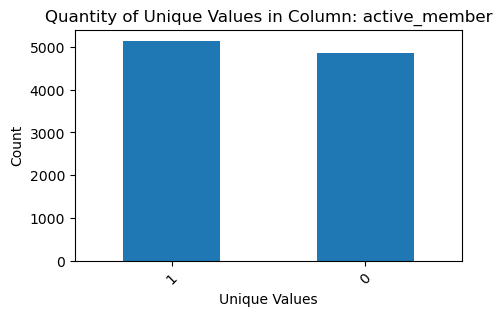

In [20]:
plot_unique_values(customer_data, 'active_member')

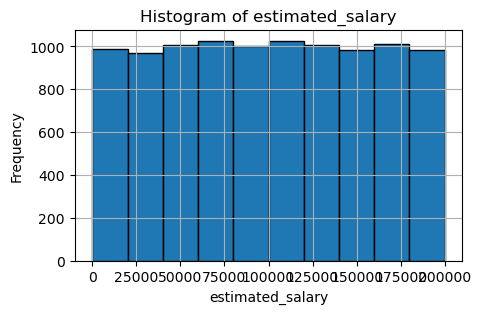

In [21]:
plot_histogram(customer_data, 'estimated_salary')

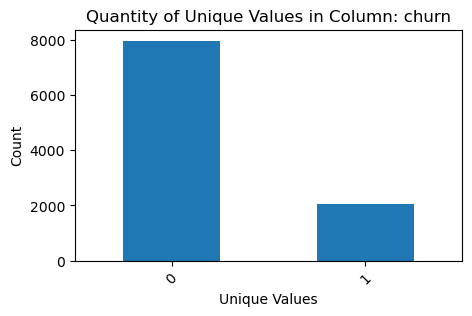

In [22]:
plot_unique_values(customer_data, 'churn')

### Baseline Model

In [23]:
customer_data.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,France,Female,42,2,0.000,1,1,1,101348.880,1
1,608,Spain,Female,41,1,83807.860,1,0,1,112542.580,0
2,502,France,Female,42,8,159660.800,3,1,0,113931.570,1
3,699,France,Female,39,1,0.000,2,0,0,93826.630,0
4,850,Spain,Female,43,2,125510.820,1,1,1,79084.100,0


In [24]:
X = customer_data.drop('churn', axis=1)
y = customer_data['churn']

In [25]:
categorical_columns = ['country', 'gender']
encoder = OneHotEncoder()
encoder.fit(X[categorical_columns])

OneHotEncoder()

In [26]:
# Save the encoder
encoder_path = 'saved_models/encoder.pkl'
joblib.dump(encoder, encoder_path)

# Transform categorical columns
X_cat = encoder.transform(X[categorical_columns]).toarray()

# Combine with numerical columns
X_num = X.drop(columns=categorical_columns).values
X_combined = np.hstack((X_num, X_cat))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

In [29]:
class ChurnModel(nn.Module):
    def __init__(self, input_dim):
        super(ChurnModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Initialize the model, loss function and optimizer
input_dim = X_train.shape[1]
model = ChurnModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
n_epochs = 20
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader)}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = (y_pred >= 0.5).float()
    accuracy = (y_pred.eq(y_test_tensor).sum() / float(y_test_tensor.shape[0])).item()
    print(f'Accuracy: {accuracy:.2f}')

Epoch 1/20, Loss: 20.6243653011322
Epoch 2/20, Loss: 20.543269319534303
Epoch 3/20, Loss: 20.6898275680542
Epoch 4/20, Loss: 20.547101690292358
Epoch 5/20, Loss: 20.547101692199707
Epoch 6/20, Loss: 20.547101692199707
Epoch 7/20, Loss: 20.547101692199707
Epoch 8/20, Loss: 20.547101692199707
Epoch 9/20, Loss: 20.547101692199707
Epoch 10/20, Loss: 20.547101690292358
Epoch 11/20, Loss: 20.547101690292358
Epoch 12/20, Loss: 20.547101692199707
Epoch 13/20, Loss: 20.547101692199707
Epoch 14/20, Loss: 20.547101692199707
Epoch 15/20, Loss: 20.547101692199707
Epoch 16/20, Loss: 20.547101692199707
Epoch 17/20, Loss: 20.547101690292358
Epoch 18/20, Loss: 20.547101692199707
Epoch 19/20, Loss: 20.547101692199707
Epoch 20/20, Loss: 20.547101692199707
Accuracy: 0.80


In [30]:
# Save the PyTorch model
model_path = 'saved_models/trial_model.pth'
torch.save(model.state_dict(), model_path)